## 데이터 불러오기 및 전처리

In [2]:
import pandas as pd

train = pd.read_csv("Data/추천시스템/MINDsmall_train/behaviors.tsv", sep="\t", header=None)
dev = pd.read_csv("Data/추천시스템/MINDsmall_dev/behaviors.tsv", sep="\t", header=None)
news = pd.read_csv("Data/추천시스템/MINDsmall_train/news.tsv", sep="\t", header=None)

columns = ["ImpressionID", "UserID", "Time", "History", "Impressions"]
train.columns = dev.columns = columns
news.columns = ["NewsID", "Category", "SubCategory", "Title", "Abstract", 
                "URL", "TitleEntities", "AbstractEntities"]

behaviors = pd.concat([train, dev], ignore_index=True)

def parse_impressions(row):
    return [i.split("-") for i in row.split()]
def get_clicked(parsed):
    return [nid for nid, label in parsed if label == "1"]

behaviors["ParsedImpressions"] = behaviors["Impressions"].apply(parse_impressions)
behaviors["ClickedNews"] = behaviors["ParsedImpressions"].apply(get_clicked)

## 분석1. 내용 기반 추천 (TF-IDF + 코사인 유사도)

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# 뉴스 제목 TF-IDF
tfidf = TfidfVectorizer(stop_words="english", max_features=1000)
tfidf_matrix = tfidf.fit_transform(news["Title"].fillna(""))

# 사용자 프로필 생성
user_profiles = {}
for _, row in behaviors.iterrows():
    user = row["UserID"]
    clicked = row["ClickedNews"]
    indices = news[news["NewsID"].isin(clicked)].index
    if len(indices) > 0:
        user_profiles[user] = tfidf_matrix[indices].mean(axis=0)

# 프로필 있는 사용자 중에서 무작위 테스트
valid_users = list(user_profiles.keys())
target_user = valid_users[0]  # 또는 random.choice(valid_users)

# 추천
user_vector = np.asarray(user_profiles[target_user])
similarities = cosine_similarity(user_vector, tfidf_matrix)
news["ContentScore"] = similarities.flatten()
top5 = news.sort_values("ContentScore", ascending=False).head(5)[["NewsID", "Title", "ContentScore"]]

In [4]:
top5

,NewsID,Title,ContentScore
45034,N58133,"George Kent, top State Department Ukraine expe...",1.000000
20988,N41034,Firsthand account of Trump's Ukraine call puts...,0.731260
27172,N2618,State Department agrees to turn over Ukraine d...,0.715489
25054,N21551,State Department's Ukraine expert testifies af...,0.708925
28814,N60351,Former Ukraine ambassador testifies Trump pres...,0.704960


In [13]:
target_user

'U13740'

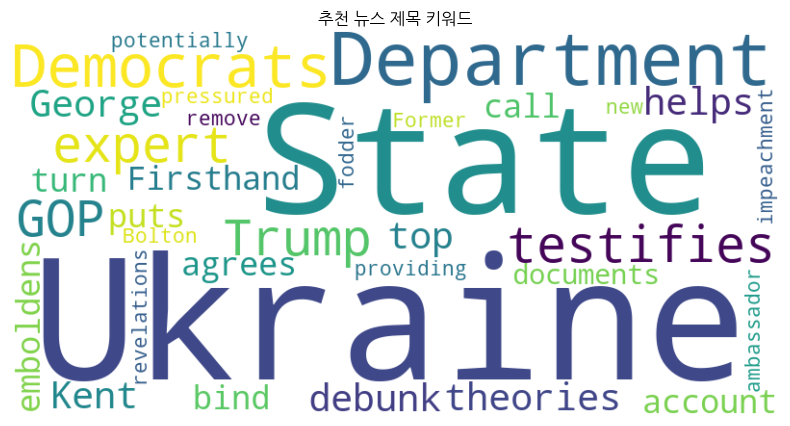

In [12]:
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import koreanize_matplotlib

text = " ".join(top5["Title"].fillna(""))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("추천 뉴스 제목 키워드")
plt.show()

사용자 프로필과 뉴스 제목 간 코사인 유사도를 기반으로 계산한 ContentScore는 해당 뉴스가 사용자의 관심 주제와 얼마나 유사한지를 0~1 범위의 수치로 나타낸다.   
> 예시 사용자에게 추천된 뉴스의 상위 5개는 모두 '우크라이나', '트럼프', '국무부' 등 정치 이슈 중심의 키워드를 포함하고 있어 관심사 기반 추천이 성공적으로 작동했음을 시사한다.   

## 분석2. 협업 필터링 - 유사 사용자 기반 클릭 예측 (User-based)

In [1]:
# 유저-뉴스 클릭 테이블 생성
clicks = []
for _, row in behaviors.iterrows():
    user = row["UserID"]
    for nid in row["ClickedNews"]:
        clicks.append((user, nid))

df_clicks = pd.DataFrame(clicks, columns=["UserID", "NewsID"])
user_item_matrix = df_clicks.pivot_table(index="UserID", columns="NewsID", aggfunc=lambda x: 1, fill_value=0)

subset_users = user_item_matrix.index[:500]
user_item_small = user_item_matrix.loc[subset_users]

# 사용자 간 유사도 계산
user_sim = cosine_similarity(user_item_small)
user_sim_df = pd.DataFrame(user_sim, index=subset_users, columns=subset_users)

target_user = subset_users[0]

# 유사한 사용자 5명 선택
sim_users = user_sim_df[target_user].sort_values(ascending=False)[1:6].index

target_clicked = set(user_item_small.loc[target_user][user_item_small.loc[target_user] > 0].index)
neighbor_clicked = set(user_item_small.loc[sim_users].sum()[user_item_small.loc[sim_users].sum() > 0].index)
recommendations = list(neighbor_clicked - target_clicked)[:5]

recommended_news = news[news["NewsID"].isin(recommendations)][["NewsID", "Title"]]
print(f"사용자: {target_user}에게 추천된 뉴스:\n")
print(recommended_news)

NameError: name 'behaviors' is not defined

협업 필터링 기법은 사용자 간의 뉴스 소비 패턴 유사성을 기반으로
관심 뉴스 예측에 활용된다. 유사한 사용자들이 클릭한 뉴스 중,
내가 아직 읽지 않은 뉴스들을 추천함으로써 새로운 관심 주제를 탐색할 수 있다.

협업 필터링 기반 추천에서는 유사한 사용자들이 관심을 가진 뉴스를 활용해
나에게 아직 읽지 않은 뉴스를 추천한다.
추천 결과는 내가 소비하지 않았던 새로운 주제를 탐색할 수 있게 하며,
사회적 유사성을 기반으로 한 뉴스 소비 확장의 효과를 기대할 수 있다.

## 추천 결과 예시 (dev 사용자 기준 Top-5)

## 결과 시각화 (클릭 많이 된 뉴스 등)

## 인사이트 도출 및 개선 방향